In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install segmentation-models

In [3]:
import numpy as np
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
import json
# import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU, Recall, Precision, BinaryAccuracy
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
learning_rate = 0.001
from keras import backend as K
from keras.utils import to_categorical
# from focal_loss import sparse_categorical_focal_loss
# from focal_loss import SparseCategoricalFocalLoss
# from tensorflow.keras.metrics import DiceCoefficient

In [4]:
# Correct recall for tf
def recall_tf(y_true, y_pred):
    Y_true = tf.dtypes.cast(y_true, tf.float32)
    Y_true = K.flatten(Y_true)
    Y_pred = tf.dtypes.cast(tf.math.greater(y_pred, 0.5), tf.float32)
    Y_pred = K.flatten(Y_pred)

    true_positives = tf.reduce_sum(Y_true * Y_pred)
    possible_positives = tf.reduce_sum(Y_true)
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

In [5]:
# Correct tf precision
def precision_tf(y_true, y_pred):
    Y_true = tf.dtypes.cast(y_true, tf.float32)
    Y_true = K.flatten(Y_true)
    Y_pred = tf.dtypes.cast(tf.math.greater(y_pred, 0.5), tf.float32)
    Y_pred = K.flatten(Y_pred)

    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(Y_true * Y_pred, 0, 1)))
    print(true_positives)
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(Y_pred, 0, 1)))
    print(predicted_positives)
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

In [6]:
# Correct tf dicecoefficient
def dice_coefficient_tf(y_true, y_pred):
    Y_true = tf.dtypes.cast(y_true, tf.float32)
    Y_true = K.flatten(Y_true)
    Y_pred = tf.dtypes.cast(tf.math.greater(y_pred, 0.5), tf.float32)
    Y_pred = K.flatten(Y_pred)

    smooth = 1e-5

    intersection = tf.reduce_sum(Y_true * Y_pred)
    union = tf.reduce_sum(Y_true) + tf.reduce_sum(Y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)


In [7]:
# Pre-Processing the training data
n_classes = 3
X_train = np.load('/content/drive/MyDrive/Dataset/liver_dataset_improoved/train2/X_train128.npy')
Y_train = np.load('/content/drive/MyDrive/Dataset/liver_dataset_improoved/train2/Y_train128.npy')

X_test = np.load('/content/drive/MyDrive/Dataset/liver_dataset_improoved/X_test128.npy')
Y_test = np.load('/content/drive/MyDrive/Dataset/liver_dataset_improoved/Y_test128.npy')

X_train = np.expand_dims(X_train, axis = 3)
#Normalizing X_train values only
X_train = normalize(X_train, axis = 1)

X_test = np.expand_dims(X_test, axis = 3)
X_test = normalize(X_test, axis = 1)


Y_train = np.expand_dims(Y_train, axis = 3)
Y_test = np.expand_dims(Y_test, axis = 3)

print("Training Data")
print(X_train.shape)
print(np.unique(X_train))

print(Y_train.shape)
print(np.unique(Y_train))

# Connverting the Y_train into categorical
Y_train_cat = to_categorical(Y_train, num_classes=n_classes)
Y_train_cat = Y_train_cat.reshape((Y_train.shape[0], Y_train.shape[1], Y_train.shape[2], n_classes))
print(Y_train_cat.shape)

Y_test_cat = to_categorical(Y_test, num_classes=n_classes)
Y_test_cat = Y_test_cat.reshape((Y_test.shape[0], Y_test.shape[1], Y_test.shape[2], n_classes))
print(Y_test_cat.shape)

Training Data
(10000, 128, 128, 1)
[0.00000000e+00 5.22079475e-04 5.32547051e-04 ... 9.99986437e-01
 9.99988443e-01 1.00000000e+00]
(10000, 128, 128, 1)
[0 1 2]
(10000, 128, 128, 3)
(1916, 128, 128, 3)


In [ ]:

IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 1
n_classes = 3  # 0, 1, 2
#Model Building
seed = 42
np.random.seed = seed
# 1) Creating the input layer. The input layer are the images of 128*128 size and channel = 1
inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))

s = inputs
# LAYER 1 #
 #Conv1
c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding= 'same')(s)
 #Dropout after c1
c1 = tf.keras.layers.Dropout(0.1)(c1)
 # Conv2
c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding= 'same')(c1)
#Applying MaxPooling of (2,2)
p1 = tf.keras.layers.MaxPooling2D(2,2)(c1)

# LAYER 2 #
c2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D(2,2)(c2)

# LAYER 3 #
c3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D(2,2)(c3)

# LAYER 4 #
c4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(c4)


# LAYER 5 #
c5 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3,3), activation = 'relu', kernel_initializer='he_normal', padding='same')(c5)

#-------------#
# Expansion Path #

# Conv2DTranspose --> Upscales the images
# Conv2D ----> Downscales the images
u6 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3,3), activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(u6)
c6 = tf. keras.layers.Dropout (0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)


u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras. layers. concatenate ([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf. keras.layers.Dropout (0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf. keras.layers .Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf. keras.layers. concatenate ([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout (0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers. concatenate ([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf. keras.layers. Dropout (0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(n_classes, (1, 1), activation= 'softmax')(c9)

model = tf.keras.Model(inputs= [inputs], outputs= [outputs])

# Loading the previous model from checkpoint
# model = tf.keras.models.load_model('/content/drive/MyDrive/Project7thSem/Liver/Unet/Categorical/unet_liver_model128.h5', custom_objects={'dice_coefficient_tf': dice_coefficient_tf, 'recall_tf': recall_tf, 'precision_tf': precision_tf})
# with open('/content/drive/MyDrive/Project7thSem/Heart_Dataset/UNet_Details/Loss_Changes/Binary_Cross/Binay_Again/training_history128.json', 'r') as file:
    # results = json.load(file)
# number_of_epochs_completed = len(results['loss'])
# model.load_weights("/content/drive/MyDrive/Project7thSem/Liver/Unet/Categorical/liver_checkpoint.h5")

model.compile(
    optimizer=Adam(learning_rate),
    loss= tf.keras.losses.CategoricalFocalCrossentropy(
                alpha=0.25,
                gamma=2.0,
                from_logits=False,
                label_smoothing=0.0,
                axis= -1,

                name='categorical_focal_crossentropy'
            ),
    metrics=[
        BinaryAccuracy(name='accuracy'),  # Binary Accuracy
        MeanIoU(num_classes=3, name='iou'),  # Intersection Over Union (IoU)
        recall_tf,  # Sensitivity
        precision_tf,
         tf.keras.metrics.BinaryIoU(
            threshold=0.5,
            name='binaryIoU',
            dtype=None
        ),
        Recall(name='recall_inbuilt'),
        Precision(name='precision_inbuilt'),
        dice_coefficient_tf  # Custom dice coefficient function
    ]
)

checkpointer = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Project7thSem/Liver/Unet/FocalLoss/liver_checkpoint.h5', verbose=1, save_best_only=True)


callbacks = [
              tf.keras.callbacks.EarlyStopping(patience = 5, monitor = 'val_loss'),
              tf.keras.callbacks.TensorBoard(log_dir = '/content/drive/MyDrive/Project7thSem/Liver/Unet/FocalLoss'),
              checkpointer
]

# Saving the accuracy as the model gets trained

results = model.fit(X_train, Y_train_cat, validation_split=0.1, batch_size=16, epochs=100,  callbacks=callbacks)
model.save('/content/drive/MyDrive/Project7thSem/Liver/Unet/FocalLoss/unet_liver_model128.h5')


# Saving the data
with open('/content/drive/MyDrive/Project7thSem/Liver/Unet/FocalLoss/training_history128.json', 'w') as file:
     json.dump(results.history, file)


Epoch 1/100
Tensor("Sum_6:0", shape=(), dtype=float32)
Tensor("Sum_7:0", shape=(), dtype=float32)
Tensor("Sum_6:0", shape=(), dtype=float32)
Tensor("Sum_7:0", shape=(), dtype=float32)
563/563 [==============================] - ETA: 0s - loss: 0.0080 - accuracy: 0.9780 - iou: 0.3470 - recall_tf: 0.9556 - precision_tf: 0.9722 - binaryIoU: 0.9516 - recall_inbuilt: 0.9556 - precision_inbuilt: 0.9781 - dice_coefficient_tf: 0.9630Tensor("Sum_6:0", shape=(), dtype=float32)
Tensor("Sum_7:0", shape=(), dtype=float32)

Epoch 1: val_loss improved from inf to 0.00440, saving model to /content/drive/MyDrive/Project7thSem/Liver/Unet/FocalLoss/liver_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


563/563 [==============================] - 62s 70ms/step - loss: 0.0080 - accuracy: 0.9780 - iou: 0.3470 - recall_tf: 0.9556 - precision_tf: 0.9722 - binaryIoU: 0.9516 - recall_inbuilt: 0.9556 - precision_inbuilt: 0.9781 - dice_coefficient_tf: 0.9630 - val_loss: 0.0044 - val_accuracy: 0.9882 - val_iou: 0.3406 - val_recall_tf: 0.9786 - val_precision_tf: 0.9859 - val_binaryIoU: 0.9738 - val_recall_inbuilt: 0.9787 - val_precision_inbuilt: 0.9859 - val_dice_coefficient_tf: 0.9822
Epoch 2/100
562/563 [============================>.] - ETA: 0s - loss: 0.0035 - accuracy: 0.9904 - iou: 0.3479 - recall_tf: 0.9826 - precision_tf: 0.9884 - binaryIoU: 0.9786 - recall_inbuilt: 0.9826 - precision_inbuilt: 0.9884 - dice_coefficient_tf: 0.9855
Epoch 2: val_loss improved from 0.00440 to 0.00299, saving model to /content/drive/MyDrive/Project7thSem/Liver/Unet/FocalLoss/liver_checkpoint.h5
563/563 [==============================] - 36s 63ms/step - loss: 0.0035 - accuracy: 0.9904 - iou: 0.3478 - recall_tf

In [ ]:
results = model.evaluate(X_test, Y_test_cat)

60/60 [==============================] - 3s 44ms/step - loss: 0.0097 - accuracy: 0.9974 - iou: 0.7776 - recall_tf: 0.9961 - precision_tf: 0.9962 - binaryIoU: 0.9942 - recall_inbuilt: 0.9961 - precision_inbuilt: 0.9962 - dice_coefficient_tf: 0.9961


In [ ]:
labels = ['loss', 'accuracy', 'iou', 'recall', 'precision', 'binaryIoU', 'recall_inbuilt', 'precision_inbuilt', 'dice_coefficient_tf']
results_dict = dict(zip(labels, results))

with open('/content/drive/MyDrive/Project7thSem/Liver/Unet/FocalLoss/Graph/testing_results_final.json', 'w') as json_file:
    json.dump(results_dict, json_file)

In [ ]:
Y_pred = model.predict(X_test)
Y_pred_argmax = np.argmax(Y_pred, axis=3)

60/60 [==============================] - 2s 20ms/step


In [ ]:
from keras.metrics import MeanIoU

n_classes = 3
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(Y_test[:,:,:,0], Y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.90621704


In [ ]:
# To calculate IoU for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)

class1_IoU = values[0, 0] / (values[0, 0] + values[0, 1] + values[0, 2] + values[1, 0] + values[2, 0])
class2_IoU = values[1, 1] / (values[1, 1] + values[1, 0] + values[1, 2] + values[0, 1] + values[2, 1])
class3_IoU = values[2, 2] / (values[2, 2] + values[2, 0] + values[2, 1] + values[0, 2] + values[1, 2])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)


[[1.6777216e+07 5.3713000e+04 1.2790000e+03]
 [4.1776000e+04 1.9744930e+06 6.9330000e+03]
 [8.0100000e+02 1.6633000e+04 9.1620000e+04]]
IoU for class1 is:  0.9942181
IoU for class2 is:  0.9431324
IoU for class3 is:  0.7813006


In [ ]:
prediction = (model.predict(X_test))

60/60 [==============================] - 1s 18ms/step


In [ ]:
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

In [ ]:

num_images = len(X_test)

# Set up subplots
fig, axes = plt.subplots(100, 3, figsize=(15, 5*100))

for i in range(100):
    # Plot original image
    axes[i, 0].imshow(X_test[i], cmap= 'gray')
    axes[i, 0].set_title('Original Image')

    # Plot ground truth mask
    ground_truth= Y_test[i]
    axes[i, 1].imshow(ground_truth[:,:,0], cmap='jet')
    axes[i, 1].set_title('Ground Truth Mask')

    # # Plot predicted mask
    axes[i, 2].imshow(predicted_img[i], cmap='gray')
    axes[i, 2].set_title('Predicted Mask')


# Adjust layout
plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 18ms/step


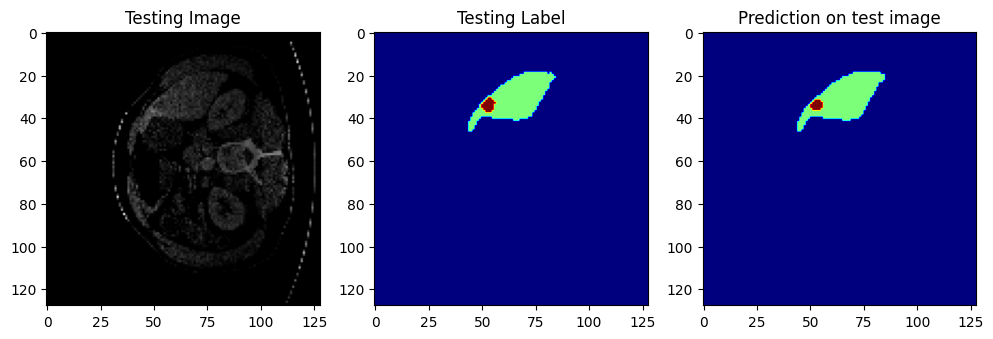

In [ ]:
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=Y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()